IMPORTING LIBRARIES

In [32]:
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling, AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
import torch
import matplotlib.pyplot as plt
import numpy as np

CODE TO CHECK IF THE GPU IS DETECTED

In [33]:
import torch
torch.cuda.empty_cache()

assert torch.cuda.is_available()

#Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: NVIDIA A100-SXM-80GB MIG 2g.20gb, n_gpu: 1


LOAD THE DATASET

In [34]:
#how to train the model without a test set.
momentum = load_dataset('json', data_files='MPM.json')
#momentum = load_dataset('json', data_files='MPM_conditioned.json', split = 'train')
#momentum = momentum.train_test_split(test_size=0.2)
flattened_mpm = momentum.flatten()
example = flattened_mpm["train"][0]
example

Found cached dataset json (/home/kkonatha/.cache/huggingface/datasets/json/default-688fdf028d397096/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)
100%|██████████| 1/1 [00:00<00:00, 704.57it/s]


{'URL': 'https://accure.ai/docs/momentum-user-guide/getting-started-with-momentum/1-getting-started-with-momentum/',
 'Product_Title': 'Momentum',
 'Section_Title': 'Getting Started with Momentum',
 'Section_Num': 1,
 'Article_Title': 'Accessing Momentum',
 'Article_Num': 1,
 'Article_Body': 'Momentum is a web-based system that is accessible via a web browser. To launch Momentum, point your browser address to: \nhttp://<public-ip-or-domain>:8800/mv-admin \nIf you installed Momentum from AWS marketplace, the default port to access Momentum is 8800. \nThe above URL will launch the login page.'}

TOKENIZE THE DATA AND ADD THE PAD TOKENS TO THE DATA

In [35]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

PREPROCESS THE DATA WITH THE REQUIRED FIELDS

In [36]:
def preprocess_function(examples):
    return tokenizer([" ".join(x) for x in examples["Article_Body"]], truncation=True)

MAP THE TOKENIZED DATA

In [37]:
tokenized_mpm = flattened_mpm.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=momentum["train"].column_names,
)

Loading cached processed dataset at /home/kkonatha/.cache/huggingface/datasets/json/default-688fdf028d397096/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e/cache-29a5e2ba64eee4e9_*_of_00004.arrow


ENCODE THE DATA WITH THE FIXED BLOCK SIZE

In [38]:
block_size = 60

def group_texts(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

PREPROCESSED DATA FOR FINE TUNING

In [39]:
mpm_dataset = tokenized_mpm.map(group_texts, batched=True, num_proc=4)

Loading cached processed dataset at /home/kkonatha/.cache/huggingface/datasets/json/default-688fdf028d397096/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e/cache-492df3d1432d8d5e_*_of_00004.arrow


In [40]:
mpm_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1025
    })
})

In [41]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [42]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
import torch

mpm_model = AutoModelForCausalLM.from_pretrained("gpt2")

In [43]:
import torch

# Get the underlying PyTorch model
model = mpm_model.transformer

# Compute the expected sequence length from the model configuration
seq_length = mpm_model.config.n_positions

# Compute the expected input shape
input_shape = (seq_length, None)

print("Input shape:", input_shape)

Input shape: (1024, None)


TRAINING THE DATA

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from transformers import TrainerCallback
import json

training_args = TrainingArguments( 
    output_dir="gpt_model",
    overwrite_output_dir=True,
    learning_rate=7e-5,
    weight_decay=0.01,
    num_train_epochs=300,
    logging_steps=50,
    save_total_limit=2,
    per_device_train_batch_size=3,
    save_steps=10_000,
    evaluation_strategy='no'
)

trainer = Trainer(
    model=mpm_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=mpm_dataset['train']
)

train_output = trainer.train()

# compute train results
metrics = train_output.metrics
max_train_samples = len(mpm_dataset)
metrics["train_samples"] = min(max_train_samples, len(mpm_dataset))

# save train results to JSON file
with open("train_metrics.json", "w") as f:
    json.dump(metrics, f)

In [ ]:
train_metrics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from transformers import TrainerCallback
import json

class LoggingCallback(TrainerCallback):
    def __init__(self):
        self.log_history = []

    def on_train_begin(self, args, state, control, **kwargs):
        self.log_history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        self.log_history.append(logs)

training_args = TrainingArguments( 
    output_dir="gpt_model",
    overwrite_output_dir=True,
    learning_rate=7e-5,
    weight_decay=0.01,
    num_train_epochs=20,
    logging_steps=50,
    save_total_limit=2,
    per_device_train_batch_size=3,
    save_steps=10_000,
    evaluation_strategy='no'
)

logging_callback = LoggingCallback()

trainer = Trainer(
    model=mpm_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=mpm_dataset['train'],
    callbacks=[logging_callback]
)

train_output = trainer.train()

# compute train results
metrics = train_output.metrics
max_train_samples = len(mpm_dataset)
metrics["train_samples"] = min(max_train_samples, len(mpm_dataset))

# save train results to JSON file
with open("train_metrics.json", "w") as f:
    json.dump(metrics, f)

# save log history to JSON file
with open("train_logs.json", "w") as f:
    json.dump(logging_callback.log_history, f)


In [ ]:
train_output

SAVE THE MODEL

In [ ]:
mpm_model.save_pretrained('/scratch/kkonatha/test8') #then need to load it to generate a test

PROMPT GENERATION

In [60]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model = AutoModelForCausalLM.from_pretrained("/scratch/kkonatha/test8")

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    
prompt = ("Momentum provides SQL-based interface for data transformation"
          " Data cleaning, null removal, datatype conversion, column renaming, mathematical transformation, blending, merging, joining with multiple data sources are some of the transformation tasks that can be performed over data created within Momentum")

input_ids = tokenizer(prompt, return_tensors="pt").input_ids
attention_mask = torch.ones_like(input_ids)

gen_tokens = model.generate(
    input_ids,
    do_sample=True,
    attention_mask=attention_mask,
    num_return_sequences=1,
    #return_dict_in_generate=True,
    temperature=0.7,
    max_length=500,
)

gen_text = tokenizer.batch_decode(gen_tokens)[0]
print(gen_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Momentum provides SQL-based interface for data transformation Data cleaning, null removal, datatype conversion, column renaming, mathematical transformation, blending, merging, joining with multiple data sources are some of the transformation tasks that can be performed over data created within Momentum   r e s u l t s   f o r   a l l   t h e   i n g e s t e r   w i IDF   t o   u s e r   h o u s e   c o n    a n e   e r   c o r e s u p   t o m e r a t   t h e   s u p  t o   t h e   u s e r e   u s e r n c t    t h a n   t h a n s e    f o u l r e    c n f o r e    s u p    t o    p a r o    s p    s p a r o c o n c e s u r e s u m e       s u b e c t s e      t o m e r e s e        c u r o n f i c a l l t           s u p l o n f i c a l o m e           s e   s e   s u b r o n f i c h          a l i b e       s u b y      l   t o l    s u b S F e       s u p l d e     s e c h a l i b S t o n f o n c r e              s u p p     l i n c r e      s e    s u p l i n e         a l i n e x  

VISUALIZATIONS

In [16]:
mpm_model.save_pretrained('/scratch/kkonatha/test8') #then need to load it to generate a test

Step,Training Loss
25000,0.090300
50000,0.080200
75000,0.074900
100000,0.072200
125000,0.070300
150000,0.068700


{'loss': 0.0903, 'learning_rate': 5.976608187134502e-05, 'epoch': 73.1}
{'loss': 0.0802, 'learning_rate': 4.9532163742690054e-05, 'epoch': 146.2}
{'loss': 0.0749, 'learning_rate': 3.929824561403508e-05, 'epoch': 219.3}
{'loss': 0.0722, 'learning_rate': 2.9064327485380114e-05, 'epoch': 292.4}
{'loss': 0.0703, 'learning_rate': 1.8830409356725144e-05, 'epoch': 365.5}
{'loss': 0.0687, 'learning_rate': 8.596491228070174e-06, 'epoch': 438.6}
{'train_runtime': 12639.7172, 'train_samples_per_second': 40.547, 'train_steps_per_second': 13.529, 'train_loss': 0.07502816326297515, 'epoch': 500.0}


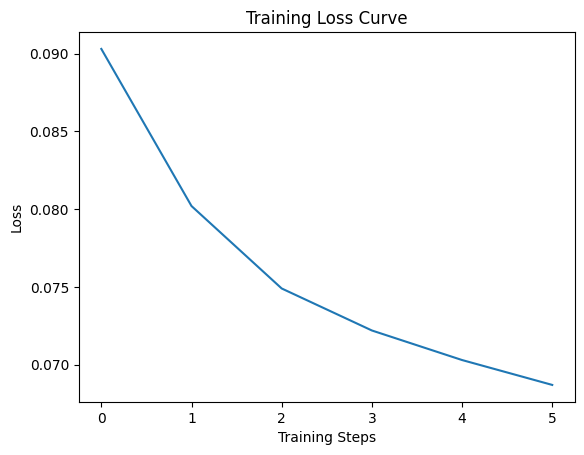

NameError: name 'fig' is not defined

In [15]:
#LOSS CURVE

import matplotlib.pyplot as plt
import numpy as np
from transformers import TrainerCallback
import json

class LoggingCallback(TrainerCallback):
    def __init__(self):
        self.log_history = []

    def on_train_begin(self, args, state, control, **kwargs):
        self.log_history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        self.log_history.append(logs)

class PrintCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            print(logs)

class LossPlotterCallback(TrainerCallback):
    def __init__(self):
        self.loss_history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        loss = logs.get("loss")
        if loss is not None:
            self.loss_history.append(loss)

    def plot_loss_curve(self):
        plt.plot(self.loss_history)
        plt.title("Training Loss Curve")
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.show()

training_args = TrainingArguments( 
    output_dir="gpt_model",
    overwrite_output_dir=True,
    learning_rate=7e-5,
    weight_decay=0.01,
    num_train_epochs=500,
    logging_steps=25000,
    save_total_limit=2,
    per_device_train_batch_size=3,
    save_steps=50_000,
    evaluation_strategy='no'
)

logging_callback = LoggingCallback()
print_callback = PrintCallback()
loss_plotter_callback = LossPlotterCallback()

trainer = Trainer(
    model=mpm_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=mpm_dataset['train'],
    callbacks=[logging_callback, print_callback, loss_plotter_callback]
)

train_output = trainer.train()

# compute train results
metrics = train_output.metrics
max_train_samples = len(mpm_dataset)
metrics["train_samples"] = min(max_train_samples, len(mpm_dataset))

# save train results to JSON file
with open("train_metrics.json", "w") as f:
    json.dump(metrics, f)

# save log history to JSON file
with open("train_logs.json", "w") as f:
    json.dump(logging_callback.log_history, f)

loss_plotter_callback.plot_loss_curve()
#fig.savefig("loss_curve.png")

/tmp/ipykernel_105398/1802481234.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')
/tmp/ipykernel_105398/1802481234.py:48: RuntimeWarning: invalid value encountered in divide
  attention_tensor = attention_tensor / np.max(attention_tensor)


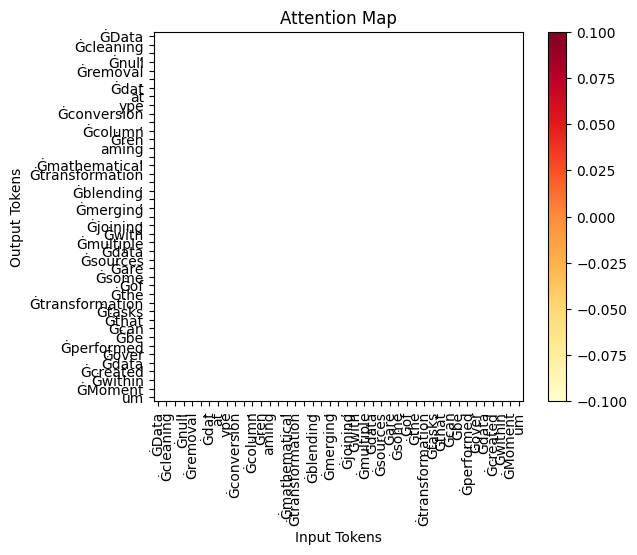

In [56]:
#ATTENTION MAP

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the GPT-2 model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModelForCausalLM.from_pretrained('gpt2', output_attentions=True)


# Define the input text
text = " Data cleaning, null removal, datatype conversion, column renaming, mathematical transformation, blending, merging, joining with multiple data sources are some of the transformation tasks that can be performed over data created within Momentum"

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt")

# Get the output of the model
outputs = model(**inputs)

# Get the attention weights from the output
attention_weights = outputs.attentions

# Define a function to plot the attention map
def plot_attention_map(attention, sentence, tokenizer):
    # Define the color map for visualizing the attention weights
    cmap = plt.cm.get_cmap('YlOrRd')
    
    # Tokenize the sentence and add the [CLS] and [SEP] tokens
    sentence_tokens = tokenizer.tokenize(sentence)
    tokens = ['[CLS]'] + sentence_tokens + ['[SEP]']
    
    # Get the attention weights for the first and last layers
    attention_first = attention[0]
    attention_last = attention[-1]
    
    # Stack the attention weights across layers
    attention_stack = torch.stack([attention_first, attention_last])
    
    # Sum the attention weights across all layers and heads
    attention_tensor = attention_stack.sum(axis=0)
    
    # Resize the attention weights to match the length of the input sentence
    attention_tensor = attention_tensor[1:-1, 1:-1].cpu().detach().numpy()
    attention_tensor = np.resize(attention_tensor, (len(sentence_tokens), len(sentence_tokens)))
    
    # Normalize the attention weights
    attention_tensor = attention_tensor / np.max(attention_tensor)
    
    # Plot the attention map
    plt.imshow(attention_tensor, cmap=cmap)
    plt.xticks(range(len(sentence_tokens)), sentence_tokens, rotation=90)
    plt.yticks(range(len(sentence_tokens)), sentence_tokens)
    plt.xlabel('Input Tokens')
    plt.ylabel('Output Tokens')
    plt.title('Attention Map')
    plt.colorbar()
    plt.show()

# Call the plot_attention_map function to plot the attention map for the input text
plot_attention_map(attention_weights, text, tokenizer)


(tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [7.9666e-01, 2.0334e-01, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [6.6418e-01, 2.7577e-01, 6.0044e-02,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [2.8095e-02, 6.8954e-03, 4.0900e-03,  ..., 1.4832e-02,
            0.0000e+00, 0.0000e+00],
           [4.4363e-02, 1.0559e-02, 1.3336e-02,  ..., 6.7285e-03,
            3.7859e-03, 0.0000e+00],
           [3.7055e-02, 8.6254e-03, 1.0625e-02,  ..., 8.1259e-03,
            8.0673e-02, 5.2602e-03]],
 
          [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [3.1109e-04, 9.9969e-01, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [1.9723e-03, 2.0384e-04, 9.9782e-01,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [2.1951e-05, 1.2541e-04, 1.